# **Programming Assignment 5: Deep k-Means: Jointly clustering with k-Means and learning representations**

This exercise implements the [DKM](https://arxiv.org/pdf/1806.10069.pdf) approach. The method study the problem of jointly clustering and learning representations.

**Assumption**: Learning representations that are both faithful to the data to be clustered and adapted to the clustering algorithm can lead to better clustering performance, all the more so that the two tasks are performed jointly.

## Deep k-Means variants

In the experiments, we considered two variants of this approach: the **Annealing** and the **Pretrained**.

**DKMa** implements an **annealing** strategy for $\alpha$ and does not rely on pretraining. In the scheme, the evolution of the $\alpha$ is given by the following recursive sequence:

$\alpha_{n+1}= 2^{1/log(n)^2} ×\alpha_n$ with $m_\alpha = \alpha_1= 0.1$

The rationale behind the choice of this scheme is that we want alpha to spend more iterations on smaller values and less on larger values while preserving a gentle slope.

**DKMp** variant is initialized by first pretraining an auto-encoder and then applying the jointly clustering approach with a constant $\alpha$ such that $m_\alpha = M_\alpha= 1000$. Such a high $\alpha$ is equivalent to having hard cluster assignments.

###**Code**

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import keras
import argparse
import seaborn as sns
import numpy as np
from tensorflow.compat.v1.keras.layers import Dense
from tensorflow.compat.v1.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.optimizers import Adam, SGD
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input
from sklearn.cluster import KMeans
!pip install visualkeras
import visualkeras
from tensorflow.compat.v1.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.compat.v1.keras import backend as K
import sklearn.metrics as metrics

###**Load dataset**

Image dataset consist of MNIST (70,000 images, 28×28 pixels, 10 classes) containing hand-written digit images.

MNIST samples (70000, 784)


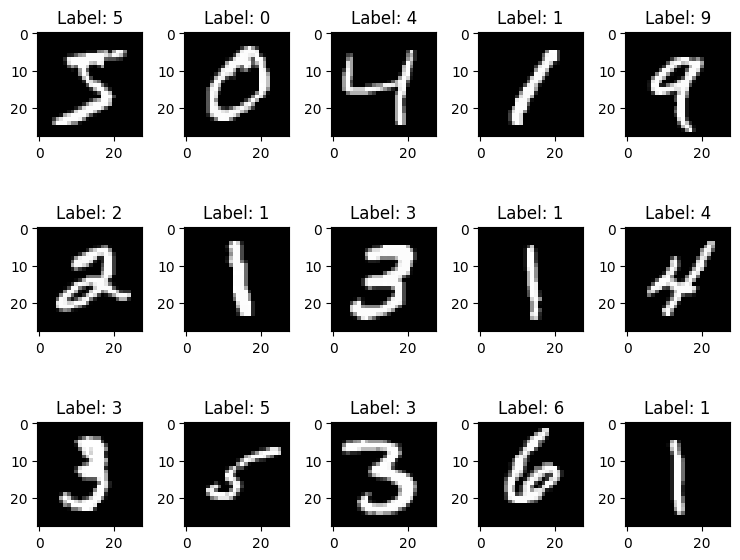

In [ ]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    # reshape x to (70000, 28*28)
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)

    num = 15
    images = x_train[:num]
    labels = y_train[:num]
    num_row = 3
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

    return x, y

x, y = load_mnist()

###**Funções Gerais**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels = None, batch_size = 64, dim = 28, n_classes=10,
                 samp_per_epoch = None, shuffle=False, flag_AE = False):
        '''
        Parameters
        ----------
        data : image stack with shape (row, col, channels*seq)
        labels : labels stack with shape (row, col, seq)
        coords : x,y coordinate for each pixel of interest
        idx_coord : index of coordinates, shape (len(coords),2)
        channels : channels of imput data for each seq. The default is 14.
        patch_size : patch size. The default is 15.
        batch_size : The default is 32.
        dim : input dimension for the CNN model. The default is (15,15,14).
        n_classes : number of classes. The default is 4.
        samp_per_epoch : (optional) # of samples for each epoch. The default is None.
        shuffle : (optional) shuffle after each epoch. The default is False.
        use_augm : (optional) data augmenattion. The default is False.

        Returns
        -------
            Datagenerator

        '''
        self.data = data
        self.label = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_classes = n_classes
        self.samp_per_epoch = samp_per_epoch
        self.flag_AE = flag_AE
        self.list_IDs = np.arange(len(self.data))

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.samp_per_epoch:
            # train over #samp_per_epoch random samples at each epoch
            return int(np.ceil(self.samp_per_epoch / self.batch_size))
        else:
            # use all avaliable samples at each epoch
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if (index+1)*self.batch_size > len(self.indexes):
            indexes = self.indexes[index*self.batch_size:]
        else:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        idx_tmp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, Y = self.__data_generation(idx_tmp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes and list coords after each epoch'
        if self.samp_per_epoch:
            self.indexes = np.arange(self.samp_per_epoch)
        else:
            self.indexes = np.arange(len(self.list_IDs))

        if self.shuffle == True:
            # shuffle indexes we use to iterate on
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((len(idx_tmp), self.dim*self.dim))

        X = self.data[idx_tmp]

        if self.flag_AE:
            return X, X

        return X, [X, np.ones((len(idx_tmp)))]


def make_autoencoder(dims, act='relu'):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer d-500-500-2000-K,
                  where d is the original data space dimension and K is the number
                  of clusters to obtain.
                  The decoder is symmetric with encoder.
        return:
            Model of autoencoder
        """
        n_stacks = len(dims) - 1
        # input
        x = Input(shape=(dims[0],), name='input')
        h = x

        # internal layers in encoder
        for i in range(n_stacks-1):
            h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)

        # hidden layer
        encoder_layer = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

        # internal layers in decoder
        for i in range(n_stacks-1, 0, -1):
            if i == n_stacks-1:
                h = encoder_layer
            h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)

        # output
        h = Dense(dims[0], name='AE_')(h)

        encoder = Model(inputs=x, outputs=encoder_layer)
        autoencoder = Model(inputs=x, outputs=h)

        return autoencoder,encoder

# Reconstruction Loss
def g_func(x, x_):
   return tf.reduce_sum(tf.square(x - x_), axis=1)

def Loss_AE():
    """The AE network is trained by minimizing the reconstruction error,
    L(x,x^), which measures the differences between our original input and
    the consequent reconstruction. """
    def loss(y_true, y_pred):
        rec_error = g_func(y_true, y_pred)
        ae_loss = tf.reduce_mean(rec_error)
        return ae_loss
    return loss


def f_func(h, rk):
   return tf.reduce_sum(tf.square(h - rk), axis=1)

class DistanceLayer(Layer):
    """ Layer which calculates the distance from each point to all centroids"""

    def __init__(self, n_clusters, weights=None, alpha = 1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(DistanceLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer, name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ## Compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, self.n_clusters):
            dist = f_func(inputs, self.clusters[i:i+1, :])
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        return tf.transpose(self.stack_dist)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(DistanceLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class  Softmax_function(Layer):
    """ Layer which calculates the softmax function from the distance
    of the samples to the centroids"""

    def __init__(self, n_clusters, weights=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Softmax_function, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)


    def build(self, input_shape):
        assert len(input_shape) == 2
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.alpha = self.add_weight(shape=(1,), initializer='glorot_uniform', name='alpha')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True


    def call(self, dists, **kwargs):

        dists = tf.transpose(dists)
        # Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(dists, axis=0)
        # Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        list_exp = []
        for i in range(self.n_clusters):
            exp = tf.exp(-self.alpha * (dists[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)
        # print(sum_exponentials.get_shape().as_list())
        #Compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(self.n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = dists[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        stack_weighted_dist = tf.transpose(stack_weighted_dist)
        return stack_weighted_dist

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0],

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(Softmax_function, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def Loss_Clustering(lambda_):

    def loss(y_true, y_pred):
        return tf.reduce_mean(tf.reduce_sum(tf.transpose(y_pred), axis=0)) * lambda_

    return loss

###**Funções de Treinamento**

In [ ]:
def pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE=10):
    # Step 1: Pretrain the autoencoder
    autoencoder.compile(optimizer=optimizer, loss=Loss_AE())

    training_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                       samp_per_epoch=None, shuffle=True, flag_AE=True)

    # Train model on dataset
    history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)

    # Step 2: Initialize cluster centers using k-means
    print('Initializing cluster centers with k-means')
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++")

    AE_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                 samp_per_epoch=None, shuffle=False, flag_AE=True)

    print('Extract Features')
    extract_features = encoder.predict_generator(AE_generator, verbose=1)

    y_pred = kmeans.fit_predict(extract_features)

    return y_pred, kmeans

def create_deep_clustering_model(autoencoder, n_stacks, n_clusters):
    hidden = autoencoder.get_layer(name='encoder_%d' % (n_stacks - 1)).output
    encoder = Model(inputs=autoencoder.input, outputs=hidden)

    distance_layer = DistanceLayer(n_clusters=n_clusters, name='distance')(hidden)
    softmax_function = Softmax_function(n_clusters, trainable=False, name='clustering')(distance_layer)

    Deep_km = Model(inputs=encoder.input, outputs=[autoencoder.output, softmax_function])
    model_see = Model(inputs=encoder.input, outputs=softmax_function)

    return Deep_km, model_see,distance_layer

def train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans=None, num_epochs_per_alpha=1):
    if Pre_train and kmeans is not None:
        Deep_km.get_layer(name='distance').set_weights([kmeans.cluster_centers_])

    deep_kmeans_gen = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10, samp_per_epoch=None, shuffle=True)

    for k in range(len(alphas)):
        print("Training step: alpha[{}]: {}".format(k, alphas[k]))

        Deep_km.get_layer(name='clustering').set_weights([alphas[k:k+1]])

        print(Deep_km.get_layer(name='clustering').get_weights()[0].reshape((-1))[0])

        history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)

    Deep_km_predictor = Model(inputs=Deep_km.input, outputs=Deep_km.get_layer(name='distance').output)

    AE_generator = DataGenerator(x, None, batch_size=256, dim=dims[0], n_classes=10, shuffle=False)

    extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)

    y_pred = np.argmin(extract_feat, axis=1)

    return y_pred

## Parâmetros e Treinamento

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
n_stacks = len(dims) - 1
autoencoder,encoder = make_autoencoder(dims)

In [ ]:
optimizer= Adam(learning_rate=1e-3)
n_clusters = 10
lambda_ = 1
num_epochs_AE = 50

#################### CODE HERE ################################

Pre_train = True
Annealing = False

#Alpha Parameter
if Annealing and not Pre_train:

    constant_value = 1  # Used to modify the range of the alpha scheme
    max_n = 40  # Number of alpha values to consider
    alphas = np.zeros(max_n, dtype=float)
    alphas[0] = 0.1
    for i in range(1, max_n):
        alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
    alphas = alphas / constant_value
    print("Annealing Scheme Done!")

elif not Annealing and Pre_train:

    constant_value = 1  # Used to modify the range of the alpha scheme
    max_n = 20  # Number of alpha values to consider
    alpha = 300
    alphas = alpha*np.ones(max_n, dtype=float) # alpha is constant
    alphas = alphas / constant_value
    print("Pre-train Scheme Done!")
else:

    parser.error("Run with either annealing or pretraining, but not both for DKM.")
    exit()
###############################################################
plt.figure(figsize=(5,5))
plt.plot(np.arange(max_n),alphas)
plt.xlabel('n',fontsize = 16); plt.ylabel(r'$\alpha_n$',fontsize = 16);

In [ ]:
Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

if Pre_train:
  y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
  y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)
else:
  y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

## **Evaluation Metrics**

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment

def assignment_cluster(y_true, y_pred):

    w = np.zeros((y_pred.max() + 1, y_true.max() + 1), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)

    aux = np.zeros_like(y_pred)
    for i in range(len(ind[0])):
        aux[y_pred == ind[0][i]] = ind[1][i]
    y_pred_map = aux

    return y_pred_map

# print(y_pred)
# y_pred_map = assignment_cluster(y, y_pred)
# print(y_pred_map)

In [ ]:
def calculate_evaluation_metrics(y_true, y_pred):
    # Calcular as métricas
    acc = np.round(metrics.accuracy_score(y_true, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y_true, y_pred), 5)
    f1score = 100 * metrics.f1_score(y_true, y_pred, average=None)

    # Retornar as métricas
    return acc, nmi, f1score

def plot_f1_score_per_class(f1score):
    # Configuração para o gráfico de barras
    classes = np.arange(len(f1score))  # as classes são numeradas de 0 a len(f1score) - 1
    width = 0.35

    # Criar o gráfico de barras
    fig, ax = plt.subplots()
    rects1 = ax.bar(classes, f1score, width, label='Digits')

    # Adicionar rótulos e título ao gráfico
    ax.set_ylabel('Scores', fontsize=15)
    ax.set_xlabel('Digits', fontsize=15)
    ax.set_title('F1 score per class', fontsize=15)
    ax.set_xticks(classes)
    ax.legend()

    # Ajustar o layout e exibir o gráfico
    fig.tight_layout()
    plt.show()

def plot_confusion_heatmap(y_true, y_pred, classes=None, figsize=(6, 6)):
    """
    Plota um heatmap da matriz de confusão normalizada.

    Parâmetros:
    - y_true: Rótulos verdadeiros.
    - y_pred: Rótulos previstos.
    - classes: Lista de classes (opcional).
    - figsize: Tamanho da figura (largura, altura).
    """
    if classes is None:
        classes = np.unique(y_true)

    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.round(cm, decimals=2)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, cbar=False, cmap="YlGnBu", linewidths=.5, linecolor='black')

    plt.title('Accuracy: ' + str(np.round(metrics.accuracy_score(y_true, y_pred), decimals=2)), fontsize=16)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.show()


In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


MNIST samples (70000, 784)


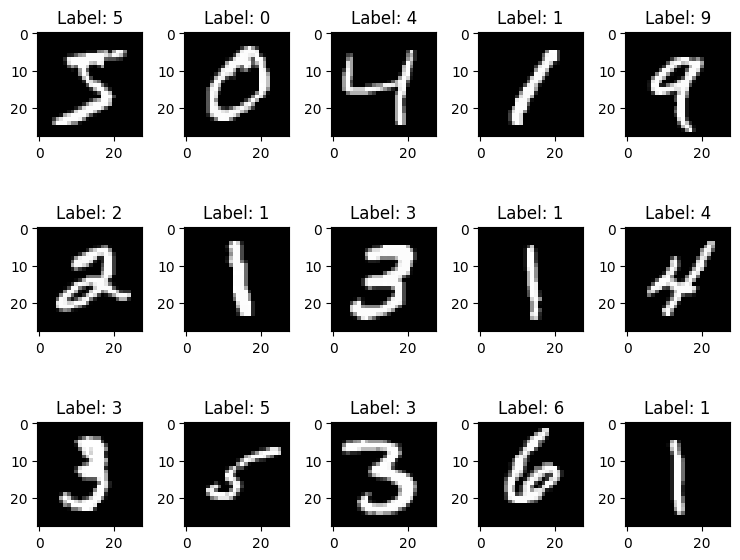

In [ ]:
# run all functions at a time

import tensorflow as tf
from tensorflow.compat.v1 import keras
import argparse
import seaborn as sns
import numpy as np
from tensorflow.compat.v1.keras.layers import Dense
from tensorflow.compat.v1.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.optimizers import Adam, SGD
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input
from sklearn.cluster import KMeans
!pip install visualkeras
import visualkeras
from tensorflow.compat.v1.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.compat.v1.keras import backend as K
import sklearn.metrics as metrics

def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    # reshape x to (70000, 28*28)
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)

    num = 15
    images = x_train[:num]
    labels = y_train[:num]
    num_row = 3
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

    return x, y

x, y = load_mnist()

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels = None, batch_size = 64, dim = 28, n_classes=10,
                 samp_per_epoch = None, shuffle=False, flag_AE = False):
        '''
        Parameters
        ----------
        data : image stack with shape (row, col, channels*seq)
        labels : labels stack with shape (row, col, seq)
        coords : x,y coordinate for each pixel of interest
        idx_coord : index of coordinates, shape (len(coords),2)
        channels : channels of imput data for each seq. The default is 14.
        patch_size : patch size. The default is 15.
        batch_size : The default is 32.
        dim : input dimension for the CNN model. The default is (15,15,14).
        n_classes : number of classes. The default is 4.
        samp_per_epoch : (optional) # of samples for each epoch. The default is None.
        shuffle : (optional) shuffle after each epoch. The default is False.
        use_augm : (optional) data augmenattion. The default is False.

        Returns
        -------
            Datagenerator

        '''
        self.data = data
        self.label = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_classes = n_classes
        self.samp_per_epoch = samp_per_epoch
        self.flag_AE = flag_AE
        self.list_IDs = np.arange(len(self.data))

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.samp_per_epoch:
            # train over #samp_per_epoch random samples at each epoch
            return int(np.ceil(self.samp_per_epoch / self.batch_size))
        else:
            # use all avaliable samples at each epoch
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if (index+1)*self.batch_size > len(self.indexes):
            indexes = self.indexes[index*self.batch_size:]
        else:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        idx_tmp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, Y = self.__data_generation(idx_tmp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes and list coords after each epoch'
        if self.samp_per_epoch:
            self.indexes = np.arange(self.samp_per_epoch)
        else:
            self.indexes = np.arange(len(self.list_IDs))

        if self.shuffle == True:
            # shuffle indexes we use to iterate on
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((len(idx_tmp), self.dim*self.dim))

        X = self.data[idx_tmp]

        if self.flag_AE:
            return X, X

        return X, [X, np.ones((len(idx_tmp)))]


def make_autoencoder(dims, act='relu'):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer d-500-500-2000-K,
                  where d is the original data space dimension and K is the number
                  of clusters to obtain.
                  The decoder is symmetric with encoder.
        return:
            Model of autoencoder
        """
        n_stacks = len(dims) - 1
        # input
        x = Input(shape=(dims[0],), name='input')
        h = x

        # internal layers in encoder
        for i in range(n_stacks-1):
            h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)

        # hidden layer
        encoder_layer = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

        # internal layers in decoder
        for i in range(n_stacks-1, 0, -1):
            if i == n_stacks-1:
                h = encoder_layer
            h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)

        # output
        h = Dense(dims[0], name='AE_')(h)

        encoder = Model(inputs=x, outputs=encoder_layer)
        autoencoder = Model(inputs=x, outputs=h)

        return autoencoder,encoder

# Reconstruction Loss
def g_func(x, x_):
   return tf.reduce_sum(tf.square(x - x_), axis=1)

def Loss_AE():
    """The AE network is trained by minimizing the reconstruction error,
    L(x,x^), which measures the differences between our original input and
    the consequent reconstruction. """
    def loss(y_true, y_pred):
        rec_error = g_func(y_true, y_pred)
        ae_loss = tf.reduce_mean(rec_error)
        return ae_loss
    return loss


def f_func(h, rk):
   return tf.reduce_sum(tf.square(h - rk), axis=1)

class DistanceLayer(Layer):
    """ Layer which calculates the distance from each point to all centroids"""

    def __init__(self, n_clusters, weights=None, alpha = 1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(DistanceLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer, name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ## Compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, self.n_clusters):
            dist = f_func(inputs, self.clusters[i:i+1, :])
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        return tf.transpose(self.stack_dist)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(DistanceLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class  Softmax_function(Layer):
    """ Layer which calculates the softmax function from the distance
    of the samples to the centroids"""

    def __init__(self, n_clusters, weights=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Softmax_function, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)


    def build(self, input_shape):
        assert len(input_shape) == 2
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.alpha = self.add_weight(shape=(1,), initializer='glorot_uniform', name='alpha')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True


    def call(self, dists, **kwargs):

        dists = tf.transpose(dists)
        # Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(dists, axis=0)
        # Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        list_exp = []
        for i in range(self.n_clusters):
            exp = tf.exp(-self.alpha * (dists[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)
        # print(sum_exponentials.get_shape().as_list())
        #Compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(self.n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = dists[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        stack_weighted_dist = tf.transpose(stack_weighted_dist)
        return stack_weighted_dist

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0],

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(Softmax_function, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def Loss_Clustering(lambda_):

    def loss(y_true, y_pred):
        return tf.reduce_mean(tf.reduce_sum(tf.transpose(y_pred), axis=0)) * lambda_

    return loss

def pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE=10):
    # Step 1: Pretrain the autoencoder
    autoencoder.compile(optimizer=optimizer, loss=Loss_AE())

    training_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                       samp_per_epoch=None, shuffle=True, flag_AE=True)

    # Train model on dataset
    history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)

    # Step 2: Initialize cluster centers using k-means
    print('Initializing cluster centers with k-means')
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++")

    AE_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                 samp_per_epoch=None, shuffle=False, flag_AE=True)

    print('Extract Features')
    extract_features = encoder.predict_generator(AE_generator, verbose=1)

    y_pred = kmeans.fit_predict(extract_features)

    return y_pred, kmeans

def create_deep_clustering_model(autoencoder, n_stacks, n_clusters):
    hidden = autoencoder.get_layer(name='encoder_%d' % (n_stacks - 1)).output
    encoder = Model(inputs=autoencoder.input, outputs=hidden)

    distance_layer = DistanceLayer(n_clusters=n_clusters, name='distance')(hidden)
    softmax_function = Softmax_function(n_clusters, trainable=False, name='clustering')(distance_layer)

    Deep_km = Model(inputs=encoder.input, outputs=[autoencoder.output, softmax_function])
    model_see = Model(inputs=encoder.input, outputs=softmax_function)

    return Deep_km, model_see,distance_layer

def train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans=None, num_epochs_per_alpha=1):
    if Pre_train and kmeans is not None:
        Deep_km.get_layer(name='distance').set_weights([kmeans.cluster_centers_])

    deep_kmeans_gen = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10, samp_per_epoch=None, shuffle=True)

    for k in range(len(alphas)):
        print("Training step: alpha[{}]: {}".format(k, alphas[k]))

        Deep_km.get_layer(name='clustering').set_weights([alphas[k:k+1]])

        print(Deep_km.get_layer(name='clustering').get_weights()[0].reshape((-1))[0])

        history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)

    Deep_km_predictor = Model(inputs=Deep_km.input, outputs=Deep_km.get_layer(name='distance').output)

    AE_generator = DataGenerator(x, None, batch_size=256, dim=dims[0], n_classes=10, shuffle=False)

    extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)

    y_pred = np.argmin(extract_feat, axis=1)

    return y_pred

import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment

def assignment_cluster(y_true, y_pred):

    w = np.zeros((y_pred.max() + 1, y_true.max() + 1), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)

    aux = np.zeros_like(y_pred)
    for i in range(len(ind[0])):
        aux[y_pred == ind[0][i]] = ind[1][i]
    y_pred_map = aux

    return y_pred_map

def calculate_evaluation_metrics(y_true, y_pred):
    # Calcular as métricas
    acc = np.round(metrics.accuracy_score(y_true, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y_true, y_pred), 5)
    f1score = 100 * metrics.f1_score(y_true, y_pred, average=None)

    # Retornar as métricas
    return acc, nmi, f1score

def plot_f1_score_per_class(f1score):
    # Configuração para o gráfico de barras
    classes = np.arange(len(f1score))  # as classes são numeradas de 0 a len(f1score) - 1
    width = 0.35

    # Criar o gráfico de barras
    fig, ax = plt.subplots()
    rects1 = ax.bar(classes, f1score, width, label='Digits')

    # Adicionar rótulos e título ao gráfico
    ax.set_ylabel('Scores', fontsize=15)
    ax.set_xlabel('Digits', fontsize=15)
    ax.set_title('F1 score per class', fontsize=15)
    ax.set_xticks(classes)
    ax.legend()

    # Ajustar o layout e exibir o gráfico
    fig.tight_layout()
    plt.show()

def plot_confusion_heatmap(y_true, y_pred, classes=None, figsize=(6, 6)):
    """
    Plota um heatmap da matriz de confusão normalizada.

    Parâmetros:
    - y_true: Rótulos verdadeiros.
    - y_pred: Rótulos previstos.
    - classes: Lista de classes (opcional).
    - figsize: Tamanho da figura (largura, altura).
    """
    if classes is None:
        classes = np.unique(y_true)

    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.round(cm, decimals=2)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, cbar=False, cmap="YlGnBu", linewidths=.5, linecolor='black')

    plt.title('Accuracy: ' + str(np.round(metrics.accuracy_score(y_true, y_pred), decimals=2)), fontsize=16)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.show()

###**Task 1**: Train the Deep k Means with different modes and alpha values, and discuss the impact of the parameters on the cluster results. Discuss also the impact on different classes.

| Configuration       | **$\alpha$**-Pretrained    | **$\alpha$**-Annealing  |**Accuracy**  |
| :-----------:        | :-----------: | :---------: |:---------: |
| 1                    |         | $\alpha_0$=0.01     ||
| 2                    |         |  $\alpha_0$=0.1      ||
| 3                    |        |  $\alpha_0$=0.5       ||
| 4                    |        | $\alpha_0$=1       ||
| 5                    | $\alpha_n$=3        |       ||
| 6                    |   $\alpha_n$= 30      |      ||
| 7                    |  $\alpha_n$= 150        |      ||
| 8                    |   $\alpha_n$=   300     |      ||

In [ ]:
# definicao de parametros gerais
optimizer= Adam(learning_rate=1e-3)
n_clusters = 10
lambda_ = 1
num_epochs_AE = 50

dims = [x.shape[-1], 500, 500, 2000, 10]
n_stacks = len(dims) - 1

In [ ]:
def get_alphas(init_alpha, n, pre_train):
  if pre_train:
    alpha = init_alpha
    alphas = alpha*np.ones(n, dtype=float)
  else:
    alphas = np.zeros(n, dtype=float)
    alphas[0] = init_alpha
    for i in range(1, n):
        alphas[i] = (2 ** (1/ (np.log(i + 1)) ** 2)) * alphas[i - 1]
  return alphas

## **$\alpha$-Annealing**

In [ ]:
Pre_train = False

### **$\alpha_0$ = 0.01**

In [ ]:
alphas = get_alphas(init_alpha=0.01, n=40, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 12s 20ms/step - loss: 36.3020 - AE__loss: 34.0410 - clustering_loss: 2.2609
Training step: alpha[1]: 0.04232086106557082
0.042320862
274/274 [==============================] - 5s 19ms/step - loss: 20.4910 - AE__loss: 19.4467 - clustering_loss: 1.0443
Training step: alpha[2]: 0.07515684111296622
0.07515684
274/274 [==============================] - 5s 18ms/step - loss: 17.2886 - AE__loss: 16.7793 - clustering_loss: 0.5093
Training step: alpha[3]: 0.10779711601958948
0.107797116
274/274 [==============================] - 5s 18ms/step - loss: 15.7220 - AE__loss: 15.4247 - clustering_loss: 0.2973
Training step: alpha[4]: 0.1408711011578593
0.14087111
274/274 [==============================] - 4s 14ms/step - loss: 14.7296 - AE__loss: 14.5123 - clustering_loss: 0.2173
Training step: alpha[5]: 0.1748191408588925
0.17481914
274/274 [==============================] - 3s 9ms/step - loss: 14.0122 - AE__loss: 13.8251 - clustering_loss: 0.1872
Training ste

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 3ms/step


Acc = 0.26897, NMI = 0.24237


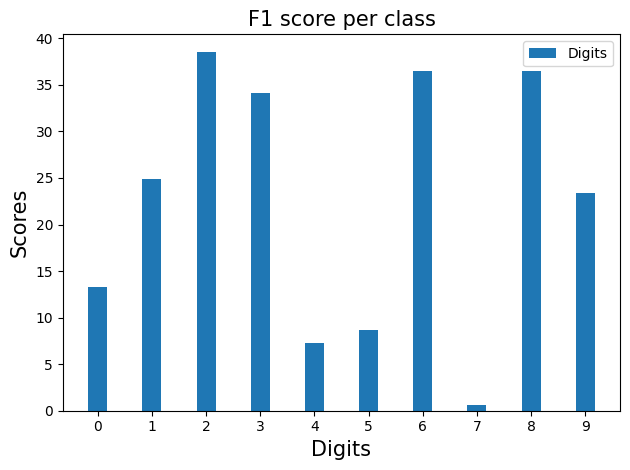

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

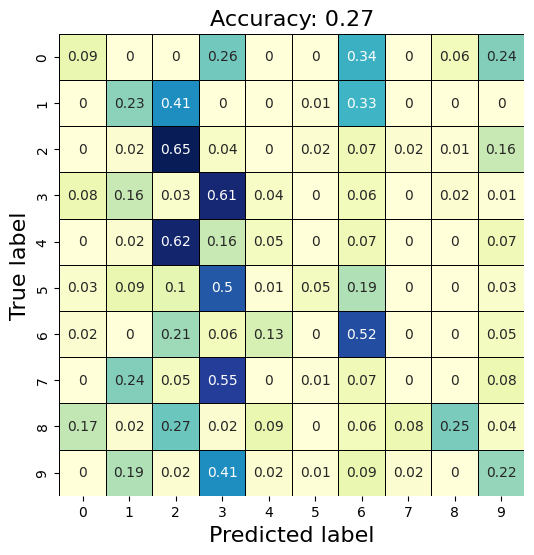

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

### **$\alpha_0 = 0.1$**

In [ ]:
alphas = get_alphas(init_alpha=0.1, n=40, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see, distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 24s 27ms/step - loss: 35.9751 - AE__loss: 33.5053 - clustering_loss: 2.4698
Training step: alpha[1]: 0.42320861065570825
0.42320862
274/274 [==============================] - 7s 27ms/step - loss: 20.7039 - AE__loss: 19.5745 - clustering_loss: 1.1294
Training step: alpha[2]: 0.7515684111296623
0.75156844
274/274 [==============================] - 6s 21ms/step - loss: 17.5348 - AE__loss: 16.9510 - clustering_loss: 0.5838
Training step: alpha[3]: 1.077971160195895
1.0779711
274/274 [==============================] - 3s 10ms/step - loss: 15.9410 - AE__loss: 15.5803 - clustering_loss: 0.3607
Training step: alpha[4]: 1.4087110115785935
1.408711
274/274 [==============================] - 3s 10ms/step - loss: 14.9185 - AE__loss: 14.6566 - clustering_loss: 0.2620
Training step: alpha[5]: 1.7481914085889256
1.7481914
274/274 [==============================] - 3s 12ms/step - loss: 14.2011 - AE__loss: 13.9855 - clustering_loss: 0.2157
Training step: alpha

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 3ms/step


Acc = 0.77979, NMI = 0.73273


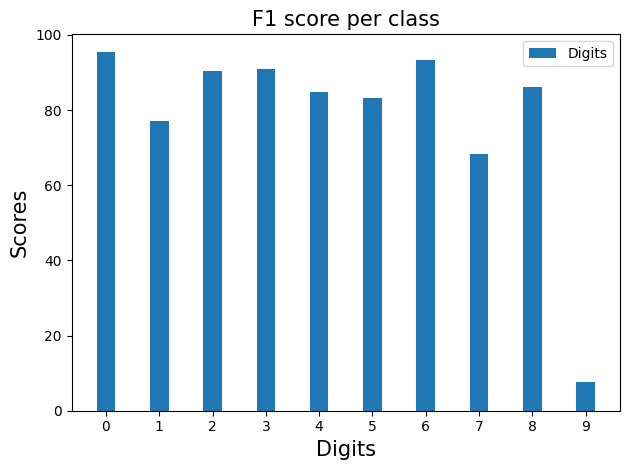

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

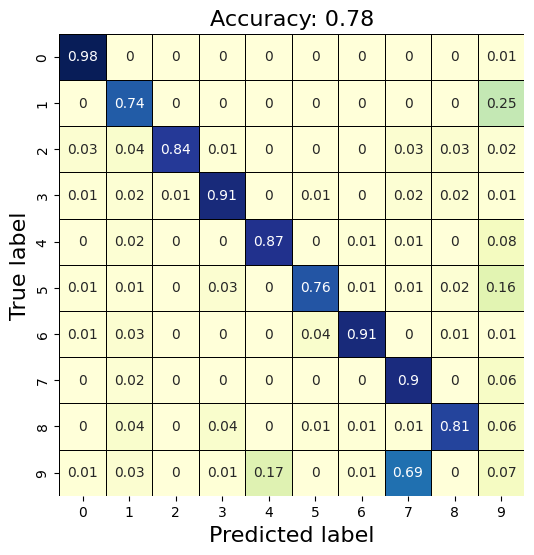

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

### **$\alpha_0 = 0.5$**



In [ ]:
alphas = get_alphas(init_alpha=0.5, n=40, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 13s 12ms/step - loss: 36.7266 - AE__loss: 34.9565 - clustering_loss: 1.7701
Training step: alpha[1]: 2.116043053278541
2.116043
274/274 [==============================] - 3s 10ms/step - loss: 21.2356 - AE__loss: 20.6907 - clustering_loss: 0.5449
Training step: alpha[2]: 3.7578420556483114
3.757842
274/274 [==============================] - 3s 10ms/step - loss: 18.5531 - AE__loss: 18.1815 - clustering_loss: 0.3717
Training step: alpha[3]: 5.389855800979475
5.389856
274/274 [==============================] - 4s 13ms/step - loss: 17.0946 - AE__loss: 16.7839 - clustering_loss: 0.3107
Training step: alpha[4]: 7.043555057892966
7.0435553
274/274 [==============================] - 3s 9ms/step - loss: 16.0320 - AE__loss: 15.7543 - clustering_loss: 0.2777
Training step: alpha[5]: 8.740957042944627
8.740957
274/274 [==============================] - 3s 10ms/step - loss: 15.2127 - AE__loss: 14.9585 - clustering_loss: 0.2542
Training step: alpha[6]: 10.49

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 4ms/step


Acc = 0.38939, NMI = 0.52971


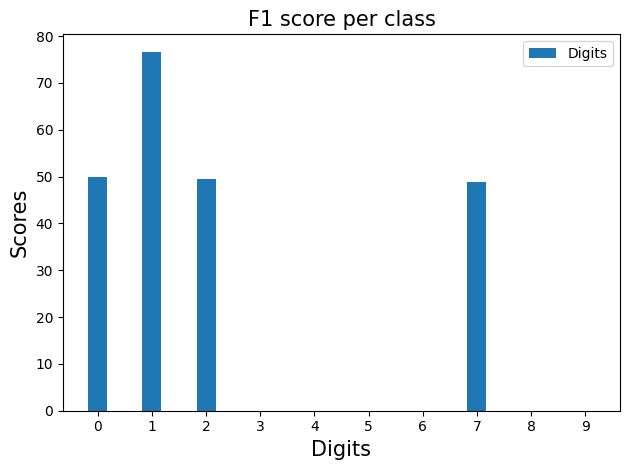

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

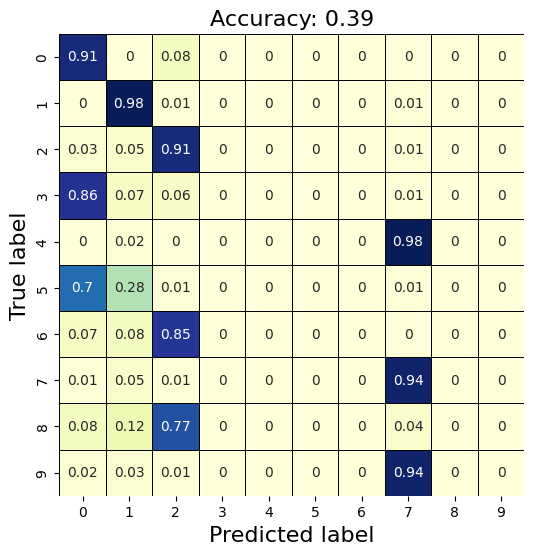

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

### **$\alpha_0 = 1$**

In [ ]:
alphas = get_alphas(init_alpha=1, n=40, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 14s 22ms/step - loss: 35.0547 - AE__loss: 34.4145 - clustering_loss: 0.6401
Training step: alpha[1]: 4.232086106557082
4.232086
274/274 [==============================] - 5s 19ms/step - loss: 20.9035 - AE__loss: 20.5622 - clustering_loss: 0.3413
Training step: alpha[2]: 7.515684111296623
7.515684
274/274 [==============================] - 3s 13ms/step - loss: 18.2205 - AE__loss: 17.9443 - clustering_loss: 0.2762
Training step: alpha[3]: 10.77971160195895
10.779712
274/274 [==============================] - 3s 9ms/step - loss: 16.9024 - AE__loss: 16.6645 - clustering_loss: 0.2379
Training step: alpha[4]: 14.087110115785933
14.0871105
274/274 [==============================] - 3s 9ms/step - loss: 15.9514 - AE__loss: 15.7396 - clustering_loss: 0.2118
Training step: alpha[5]: 17.481914085889255
17.481915
274/274 [==============================] - 3s 10ms/step - loss: 15.2077 - AE__loss: 15.0111 - clustering_loss: 0.1966
Training step: alpha[6]: 20

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 4ms/step


Acc = 0.11253, NMI = 0.00000


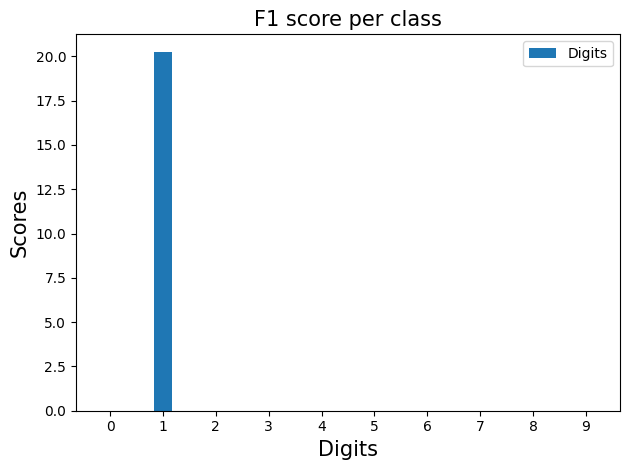

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

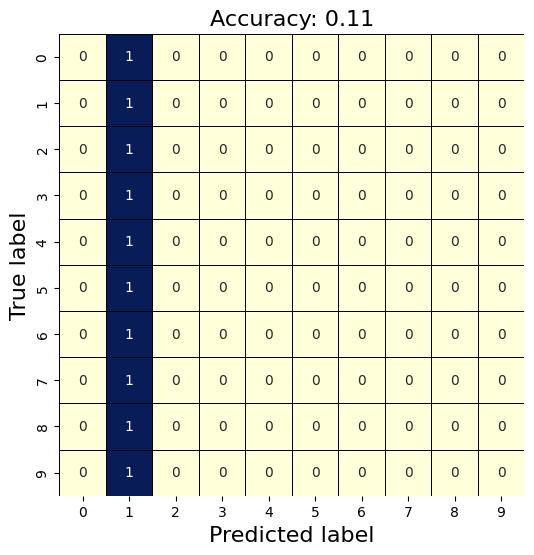

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

---

## **$\alpha$-Pretrained**

In [ ]:
Pre_train = True

### **$\alpha_n = 3$**

In [ ]:
alphas = get_alphas(init_alpha=3, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 4s 7ms/step - loss: 27.0767
Epoch 2/50
274/274 [==============================] - 2s 7ms/step - loss: 16.5039
Epoch 3/50
274/274 [==============================] - 3s 12ms/step - loss: 14.6524
Epoch 4/50
274/274 [==============================] - 3s 10ms/step - loss: 13.5916
Epoch 5/50
274/274 [==============================] - 3s 10ms/step - loss: 12.8887
Epoch 6/50
274/274 [==============================] - 3s 10ms/step - loss: 12.3266
Epoch 7/50
274/274 [==============================] - 4s 15ms/step - loss: 11.8861
Epoch 8/50
274/274 [==============================] - 3s 10ms/step - loss: 11.5385
Epoch 9/50
274/274 [==============================] - 2s 7ms/step - loss: 11.1998
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 10.9181
Epoch 11/50
274/274 [==============================] - 2s 7ms/step - loss: 10.6858
Epoch 12/50
274/274 [==============================] - 2s 7ms/step - loss: 10.4912
Epoch 13/50
274/27

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 3.0
3.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 5s 9ms/step - loss: 9.5515 - AE__loss: 8.1678 - clustering_loss: 1.3838
Training step: alpha[1]: 3.0
3.0
274/274 [==============================] - 5s 20ms/step - loss: 8.8376 - AE__loss: 8.0539 - clustering_loss: 0.7837
Training step: alpha[2]: 3.0
3.0
274/274 [==============================] - 3s 12ms/step - loss: 8.5964 - AE__loss: 7.9446 - clustering_loss: 0.6518
Training step: alpha[3]: 3.0
3.0
274/274 [==============================] - 3s 9ms/step - loss: 8.4239 - AE__loss: 7.8367 - clustering_loss: 0.5872
Training step: alpha[4]: 3.0
3.0
274/274 [==============================] - 3s 10ms/step - loss: 8.3487 - AE__loss: 7.8004 - clustering_loss: 0.5483
Training step: alpha[5]: 3.0
3.0
274/274 [==============================] - 3s 12ms/step - loss: 8.2832 - AE__loss: 7.7617 - clustering_loss: 0.5215
Training step: alpha[6]: 3.0
3.0
274/274 [==============================] - 3s 10ms/step - loss: 8.2279 - AE__loss: 7.7270 - clustering_loss:

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.88240, NMI = 0.81321


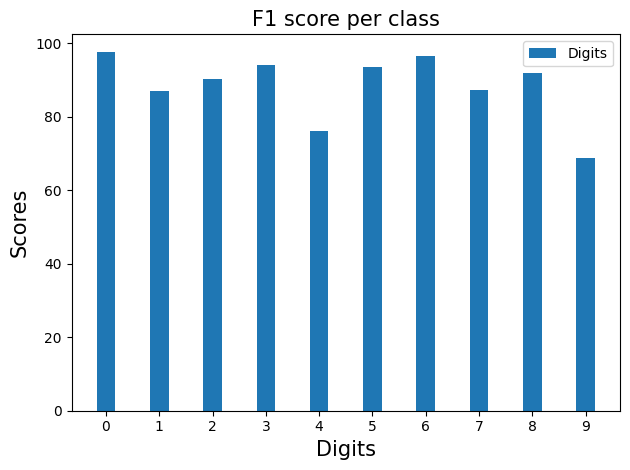

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

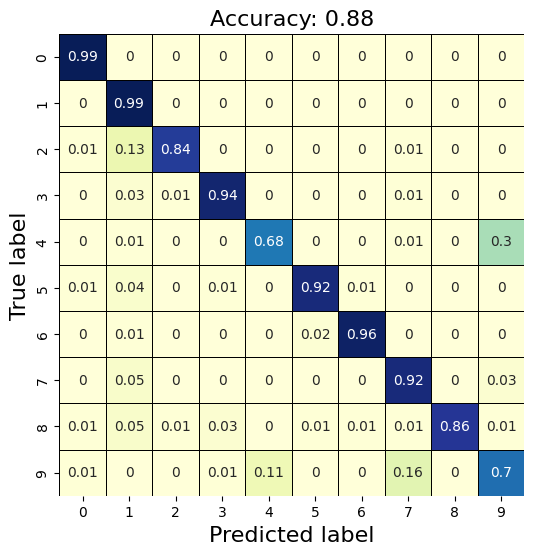

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

### **$\alpha_n = 30$**

In [ ]:
alphas = get_alphas(init_alpha=30, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 6s 11ms/step - loss: 28.1919
Epoch 2/50
274/274 [==============================] - 3s 9ms/step - loss: 16.9850
Epoch 3/50
274/274 [==============================] - 2s 9ms/step - loss: 14.9058
Epoch 4/50
274/274 [==============================] - 3s 10ms/step - loss: 13.7649
Epoch 5/50
274/274 [==============================] - 3s 11ms/step - loss: 13.0094
Epoch 6/50
274/274 [==============================] - 3s 12ms/step - loss: 12.4207
Epoch 7/50
274/274 [==============================] - 3s 10ms/step - loss: 11.9858
Epoch 8/50
274/274 [==============================] - 3s 11ms/step - loss: 11.6115
Epoch 9/50
274/274 [==============================] - 4s 15ms/step - loss: 11.2762
Epoch 10/50
274/274 [==============================] - 2s 7ms/step - loss: 11.0308
Epoch 11/50
274/274 [==============================] - 2s 8ms/step - loss: 10.7802
Epoch 12/50
274/274 [==============================] - 3s 9ms/step - loss: 10.5489
Epoch 13/50
274/2

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 30.0
30.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 5s 10ms/step - loss: 9.8419 - AE__loss: 8.3224 - clustering_loss: 1.5194
Training step: alpha[1]: 30.0
30.0
274/274 [==============================] - 3s 9ms/step - loss: 8.9383 - AE__loss: 8.1554 - clustering_loss: 0.7829
Training step: alpha[2]: 30.0
30.0
274/274 [==============================] - 3s 11ms/step - loss: 8.6265 - AE__loss: 8.0461 - clustering_loss: 0.5804
Training step: alpha[3]: 30.0
30.0
274/274 [==============================] - 4s 13ms/step - loss: 8.4496 - AE__loss: 7.9783 - clustering_loss: 0.4713
Training step: alpha[4]: 30.0
30.0
274/274 [==============================] - 3s 10ms/step - loss: 8.3332 - AE__loss: 7.9328 - clustering_loss: 0.4004
Training step: alpha[5]: 30.0
30.0
274/274 [==============================] - 3s 10ms/step - loss: 8.2266 - AE__loss: 7.8754 - clustering_loss: 0.3512
Training step: alpha[6]: 30.0
30.0
274/274 [==============================] - 4s 13ms/step - loss: 8.1385 - AE__loss: 7.8248 - clu

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.80461, NMI = 0.80295


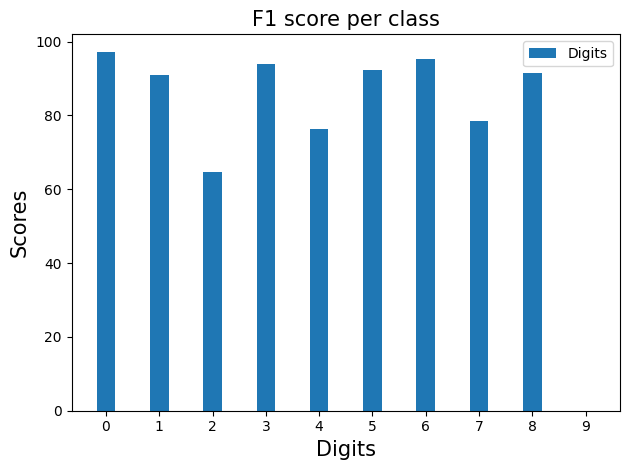

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

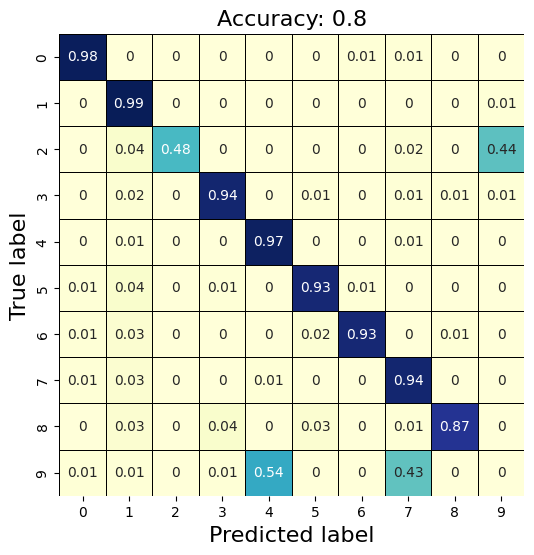

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

### **$\alpha_n = 150$**

In [ ]:
alphas = get_alphas(init_alpha=150, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 10s 12ms/step - loss: 27.4505
Epoch 2/50
274/274 [==============================] - 4s 14ms/step - loss: 16.6345
Epoch 3/50
274/274 [==============================] - 5s 19ms/step - loss: 14.6607
Epoch 4/50
274/274 [==============================] - 3s 13ms/step - loss: 13.5847
Epoch 5/50
274/274 [==============================] - 4s 14ms/step - loss: 12.8112
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 12.2499
Epoch 7/50
274/274 [==============================] - 1s 5ms/step - loss: 11.8063
Epoch 8/50
274/274 [==============================] - 1s 5ms/step - loss: 11.4409
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.1147
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 10.8159
Epoch 11/50
274/274 [==============================] - 1s 5ms/step - loss: 10.6271
Epoch 12/50
274/274 [==============================] - 2s 7ms/step - loss: 10.3766
Epoch 13/50
274/27

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 150.0
150.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 6s 11ms/step - loss: 9.6770 - AE__loss: 8.2125 - clustering_loss: 1.4644
Training step: alpha[1]: 150.0
150.0
274/274 [==============================] - 3s 10ms/step - loss: 8.8058 - AE__loss: 8.0367 - clustering_loss: 0.7691
Training step: alpha[2]: 150.0
150.0
274/274 [==============================] - 4s 15ms/step - loss: 8.5124 - AE__loss: 7.9375 - clustering_loss: 0.5750
Training step: alpha[3]: 150.0
150.0
274/274 [==============================] - 3s 10ms/step - loss: 8.3199 - AE__loss: 7.8542 - clustering_loss: 0.4657
Training step: alpha[4]: 150.0
150.0
274/274 [==============================] - 3s 10ms/step - loss: 8.2071 - AE__loss: 7.8111 - clustering_loss: 0.3960
Training step: alpha[5]: 150.0
150.0
274/274 [==============================] - 4s 14ms/step - loss: 8.1233 - AE__loss: 7.7763 - clustering_loss: 0.3470
Training step: alpha[6]: 150.0
150.0
274/274 [==============================] - 3s 9ms/step - loss: 8.0487 - AE__loss: 

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 4ms/step


Acc = 0.85407, NMI = 0.79906


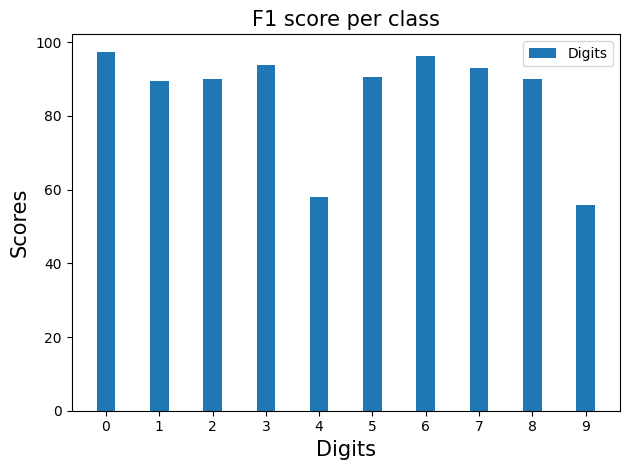

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

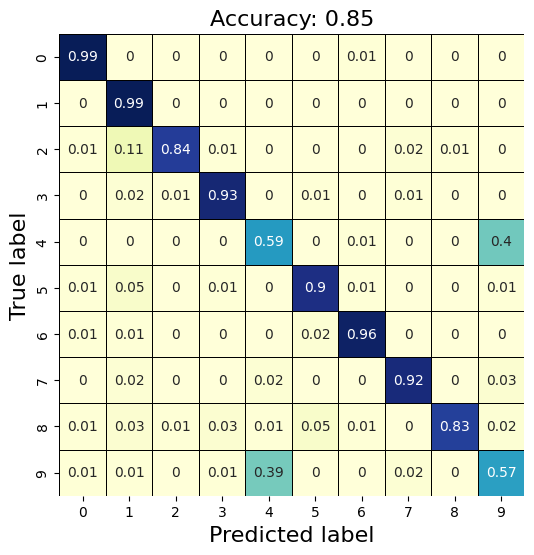

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

### **$\alpha_n = 300$**

In [ ]:
alphas = get_alphas(init_alpha=300, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 5s 6ms/step - loss: 29.1811
Epoch 2/50
274/274 [==============================] - 1s 5ms/step - loss: 17.0255
Epoch 3/50
274/274 [==============================] - 1s 5ms/step - loss: 14.9896
Epoch 4/50
274/274 [==============================] - 1s 5ms/step - loss: 13.8806
Epoch 5/50
274/274 [==============================] - 1s 5ms/step - loss: 13.1329
Epoch 6/50
274/274 [==============================] - 1s 5ms/step - loss: 12.6114
Epoch 7/50
274/274 [==============================] - 2s 7ms/step - loss: 12.1340
Epoch 8/50
274/274 [==============================] - 2s 7ms/step - loss: 11.7473
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.4593
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 11.1880
Epoch 11/50
274/274 [==============================] - 1s 5ms/step - loss: 10.9477
Epoch 12/50
274/274 [==============================] - 1s 5ms/step - loss: 10.7530
Epoch 13/50
274/274 [===

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 6s 11ms/step - loss: 10.0239 - AE__loss: 8.4530 - clustering_loss: 1.5709
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 3s 9ms/step - loss: 9.1047 - AE__loss: 8.2843 - clustering_loss: 0.8204
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 3s 9ms/step - loss: 8.7708 - AE__loss: 8.1620 - clustering_loss: 0.6088
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.5773 - AE__loss: 8.0848 - clustering_loss: 0.4925
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 4s 14ms/step - loss: 8.4219 - AE__loss: 8.0056 - clustering_loss: 0.4164
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.3486 - AE__loss: 7.9851 - clustering_loss: 0.3634
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.2594 - AE__loss: 

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 3ms/step


Acc = 0.90134, NMI = 0.82270


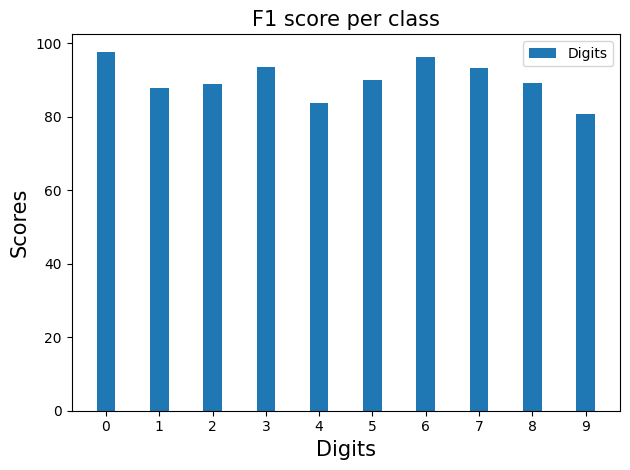

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

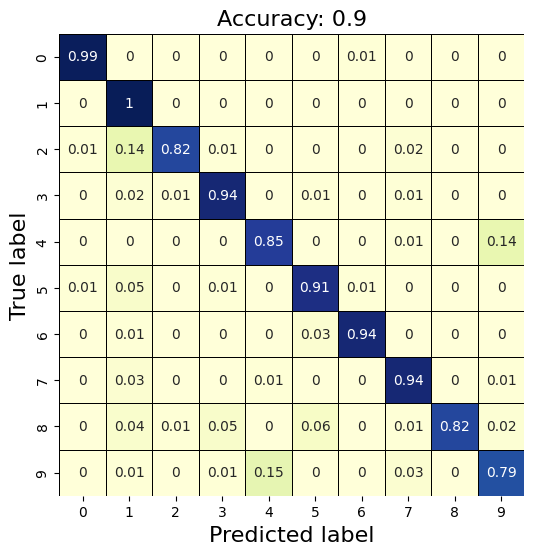

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

---

###**Task 2**: Vary the number of clusters for the best result configuration: 2, 5, 10, 20. Comment on how the clusters group the classes and show examples of images and/or the original classes distribution in each cluster to justify the discussion.

In [ ]:
Pre_train = True

In [ ]:
def plot_samples_clusters(num_row, num_col, x, y, y_pred_map):
    fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,3*num_row))

    for i, label in enumerate(np.unique(y_pred)):
        idx = np.where(y_pred == label)[0]
        if len(idx) > num_col:
            idx = np.random.choice(idx, num_col, replace=False)

        for j, index in enumerate(idx):
            ax = axes[i, j]

            if y[index] == y_pred_map[index]:
                ax.imshow(x[index].reshape(28,28), cmap='Greens')

            else:
                ax.imshow(x[index].reshape(28,28), cmap='Reds')

            ax.set_title(f'real: {y[index]}, pred: {y_pred_map[index]}')

            if j == 0:
              ax.set_ylabel(f"Cluster: {label}")

    plt.show()

### $n_\text{clusters} = 2$

In [ ]:
n_clusters = 2

alphas = get_alphas(init_alpha=300, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 2)                 20        
                                                                 
 clustering (Softmax_functi  (None, 2)                 1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 6s 10ms/step - loss: 29.8406
Epoch 2/50
274/274 [==============================] - 3s 9ms/step - loss: 17.0698
Epoch 3/50
274/274 [==============================] - 4s 14ms/step - loss: 14.9805
Epoch 4/50
274/274 [==============================] - 3s 11ms/step - loss: 13.8535
Epoch 5/50
274/274 [==============================] - 3s 11ms/step - loss: 13.0898
Epoch 6/50
274/274 [==============================] - 4s 14ms/step - loss: 12.5101
Epoch 7/50
274/274 [==============================] - 3s 11ms/step - loss: 12.0614
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 11.6538
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.3540
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 11.0679
Epoch 11/50
274/274 [==============================] - 1s 5ms/step - loss: 10.8096
Epoch 12/50
274/274 [==============================] - 2s 7ms/step - loss: 10.6097
Epoch 13/50
274/27

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 4s 10ms/step - loss: 10.4446 - AE__loss: 8.7424 - clustering_loss: 1.7023
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 9.1788 - AE__loss: 8.4009 - clustering_loss: 0.7779
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 2s 7ms/step - loss: 8.8388 - AE__loss: 8.2553 - clustering_loss: 0.5835
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 2s 7ms/step - loss: 8.6207 - AE__loss: 8.1392 - clustering_loss: 0.4815
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 2s 9ms/step - loss: 8.4808 - AE__loss: 8.0666 - clustering_loss: 0.4142
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.3625 - AE__loss: 7.9969 - clustering_loss: 0.3656
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 3s 11ms/step - loss: 8.2835 - AE__loss: 7.

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.20877, NMI = 0.27290


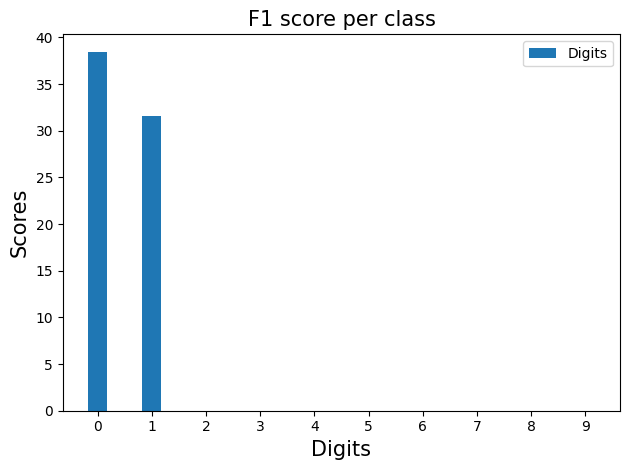

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

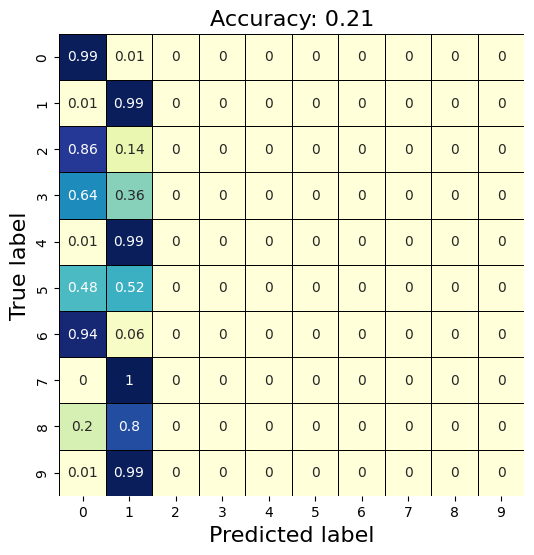

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

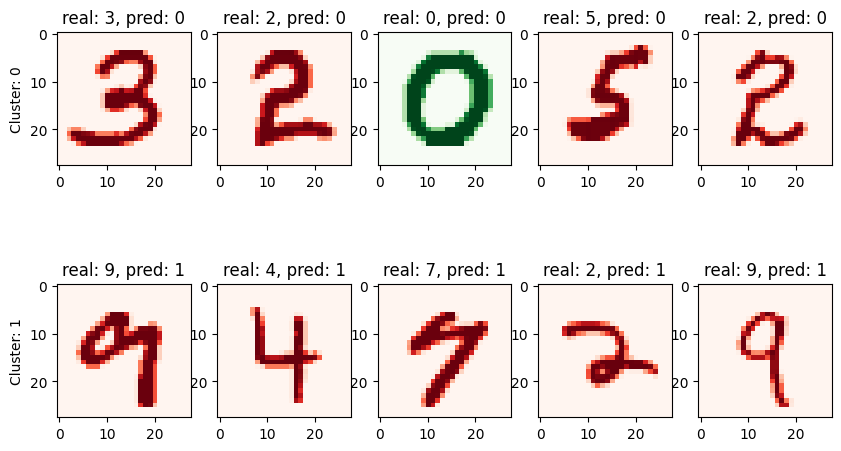

In [ ]:
plot_samples_clusters(n_clusters, 5, x, y, y_pred_map)

### $n_\text{clusters} = 5$

In [ ]:
n_clusters = 5

alphas = get_alphas(init_alpha=300, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 5)                 50        
                                                                 
 clustering (Softmax_functi  (None, 5)                 1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 8s 11ms/step - loss: 28.4834
Epoch 2/50
274/274 [==============================] - 3s 10ms/step - loss: 16.7496
Epoch 3/50
274/274 [==============================] - 4s 14ms/step - loss: 14.7502
Epoch 4/50
274/274 [==============================] - 3s 11ms/step - loss: 13.6666
Epoch 5/50
274/274 [==============================] - 3s 10ms/step - loss: 12.9299
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 12.3647
Epoch 7/50
274/274 [==============================] - 2s 7ms/step - loss: 11.9243
Epoch 8/50
274/274 [==============================] - 2s 7ms/step - loss: 11.5535
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.2545
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 10.9949
Epoch 11/50
274/274 [==============================] - 1s 5ms/step - loss: 10.7485
Epoch 12/50
274/274 [==============================] - 1s 5ms/step - loss: 10.5431
Epoch 13/50
274/274

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 6s 12ms/step - loss: 10.2534 - AE__loss: 8.6088 - clustering_loss: 1.6447
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 9.1488 - AE__loss: 8.3482 - clustering_loss: 0.8006
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 8.7895 - AE__loss: 8.1954 - clustering_loss: 0.5941
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 8.5789 - AE__loss: 8.0975 - clustering_loss: 0.4815
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 2s 9ms/step - loss: 8.4413 - AE__loss: 8.0313 - clustering_loss: 0.4100
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 3s 12ms/step - loss: 8.3634 - AE__loss: 8.0041 - clustering_loss: 0.3593
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 8.2744 - AE__loss: 7.9

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.49081, NMI = 0.63156


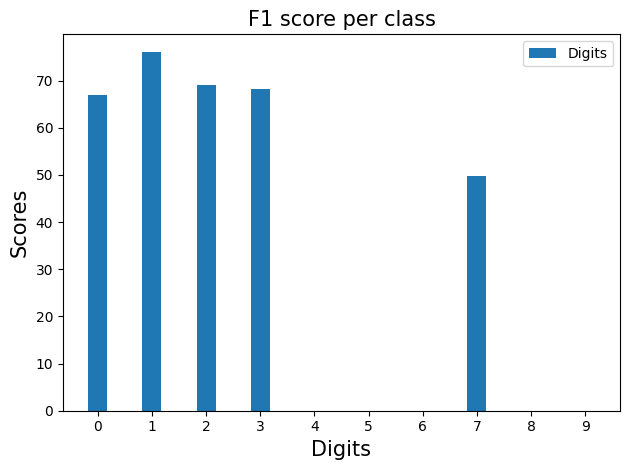

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

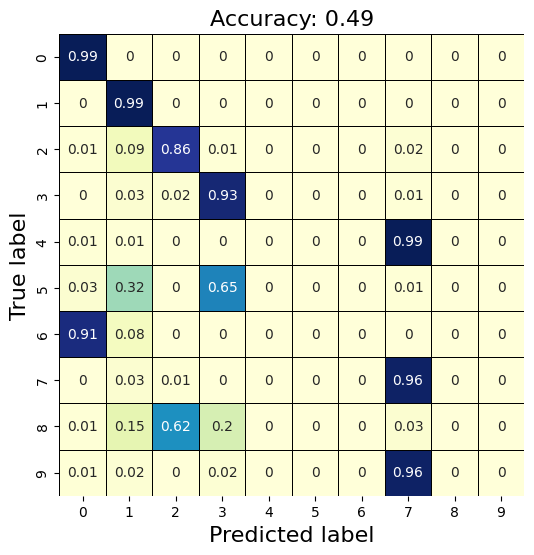

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

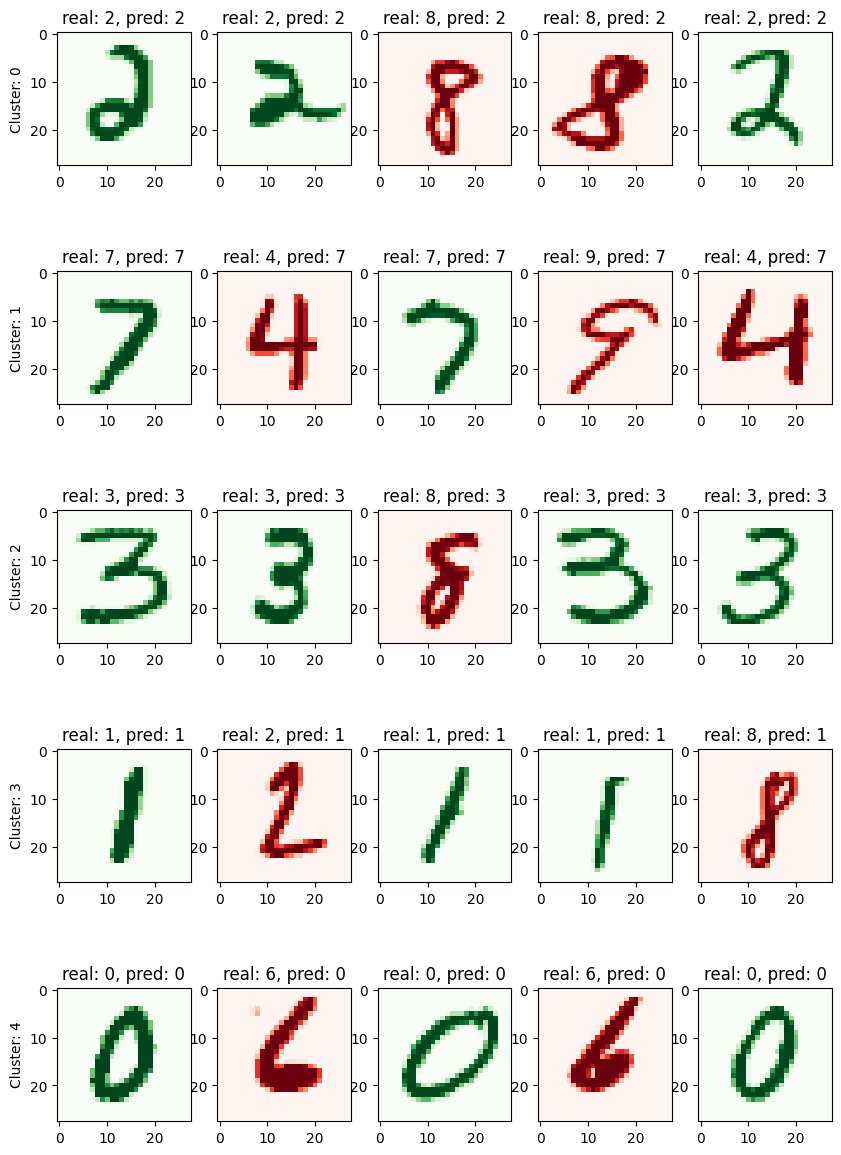

In [ ]:
plot_samples_clusters(n_clusters, 5, x, y, y_pred_map)

### $n_\text{clusters} = 10$

In [ ]:
n_clusters = 10

alphas = get_alphas(init_alpha=300, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 6s 8ms/step - loss: 29.9599
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 17.0470
Epoch 3/50
274/274 [==============================] - 2s 7ms/step - loss: 14.8816
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 13.7016
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 12.9267
Epoch 6/50
274/274 [==============================] - 2s 5ms/step - loss: 12.3620
Epoch 7/50
274/274 [==============================] - 1s 5ms/step - loss: 11.9057
Epoch 8/50
274/274 [==============================] - 1s 5ms/step - loss: 11.5446
Epoch 9/50
274/274 [==============================] - 2s 5ms/step - loss: 11.2116
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 10.9511
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 10.7094
Epoch 12/50
274/274 [==============================] - 2s 7ms/step - loss: 10.4867
Epoch 13/50
274/274 [===

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 6s 11ms/step - loss: 9.6588 - AE__loss: 8.2213 - clustering_loss: 1.4374
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.8410 - AE__loss: 8.0883 - clustering_loss: 0.7528
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.5465 - AE__loss: 7.9859 - clustering_loss: 0.5606
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.3725 - AE__loss: 7.9164 - clustering_loss: 0.4561
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.2604 - AE__loss: 7.8722 - clustering_loss: 0.3882
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 3s 12ms/step - loss: 8.1654 - AE__loss: 7.8255 - clustering_loss: 0.3398
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 4s 13ms/step - loss: 8.0685 - AE__loss:

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 4ms/step


Acc = 0.87204, NMI = 0.80060


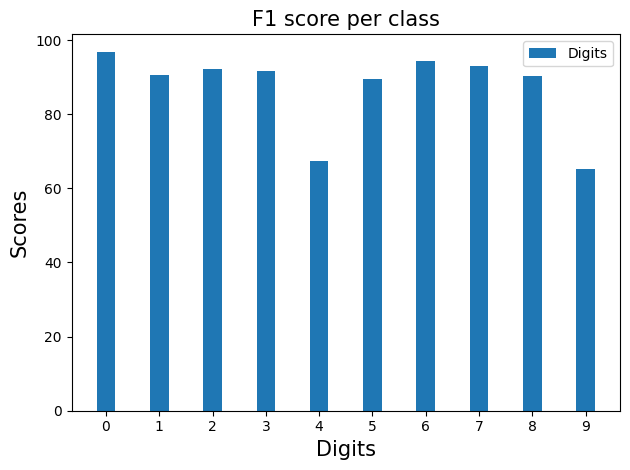

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

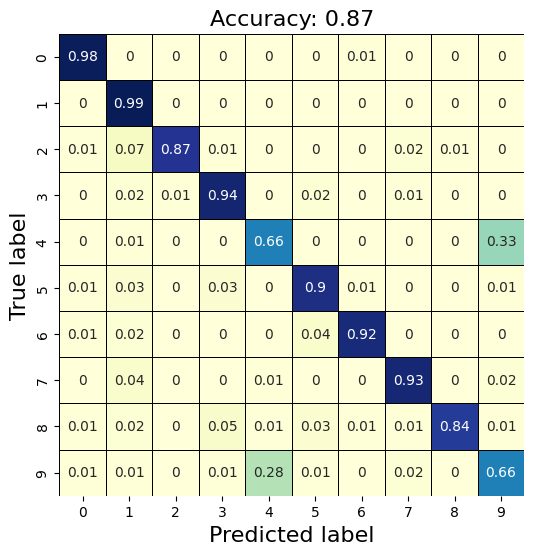

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

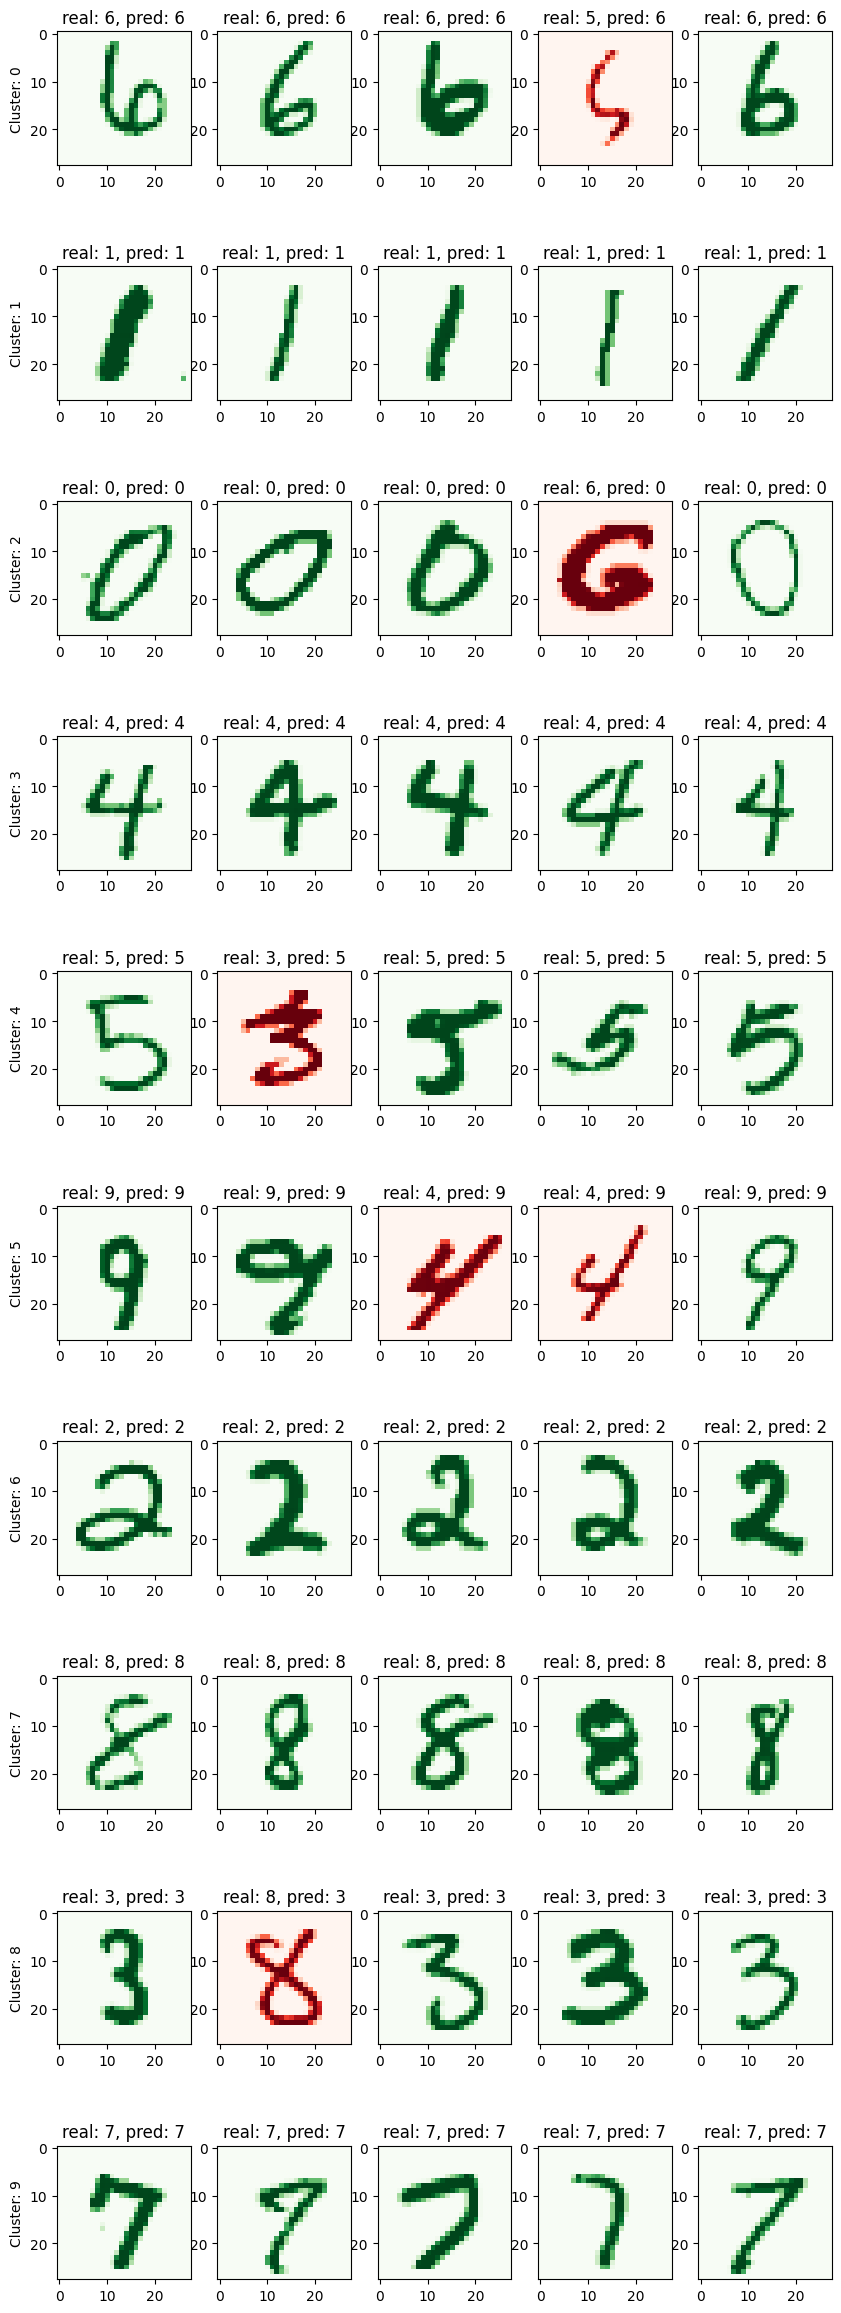

In [ ]:
plot_samples_clusters(n_clusters, 5, x, y, y_pred_map)

### $n_\text{clusters} = 20$

In [ ]:
n_clusters = 20

alphas = get_alphas(init_alpha=300, n=20, pre_train=Pre_train)

autoencoder, encoder = make_autoencoder(dims)

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)

y_pred_map = assignment_cluster(y, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 20)                200       
                                                                 
 clustering (Softmax_functi  (None, 20)                1   

<ipython-input-1-fd217c49066f>:307: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 6s 10ms/step - loss: 32.1959
Epoch 2/50
274/274 [==============================] - 3s 9ms/step - loss: 17.5466
Epoch 3/50
274/274 [==============================] - 4s 13ms/step - loss: 15.2187
Epoch 4/50
274/274 [==============================] - 3s 11ms/step - loss: 14.0180
Epoch 5/50
274/274 [==============================] - 3s 10ms/step - loss: 13.2375
Epoch 6/50
274/274 [==============================] - 3s 10ms/step - loss: 12.6283
Epoch 7/50
274/274 [==============================] - 4s 13ms/step - loss: 12.1537
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 11.7902
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.4632
Epoch 10/50
274/274 [==============================] - 2s 5ms/step - loss: 11.2330
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 10.9584
Epoch 12/50
274/274 [==============================] - 2s 8ms/step - loss: 10.7414
Epoch 13/50
274/27

<ipython-input-1-fd217c49066f>:317: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-1-fd217c49066f>:348: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 10s 17ms/step - loss: 9.7223 - AE__loss: 8.2823 - clustering_loss: 1.4400
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 4s 14ms/step - loss: 8.9389 - AE__loss: 8.1548 - clustering_loss: 0.7841
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 4s 13ms/step - loss: 8.6638 - AE__loss: 8.0814 - clustering_loss: 0.5824
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 5s 18ms/step - loss: 8.4778 - AE__loss: 8.0058 - clustering_loss: 0.4720
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 4s 15ms/step - loss: 8.3317 - AE__loss: 7.9334 - clustering_loss: 0.3983
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 4s 14ms/step - loss: 8.2593 - AE__loss: 7.9122 - clustering_loss: 0.3471
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 5s 19ms/step - loss: 8.1892 - AE__loss

<ipython-input-1-fd217c49066f>:354: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 3s 5ms/step


Acc = 0.55646, NMI = 0.49105


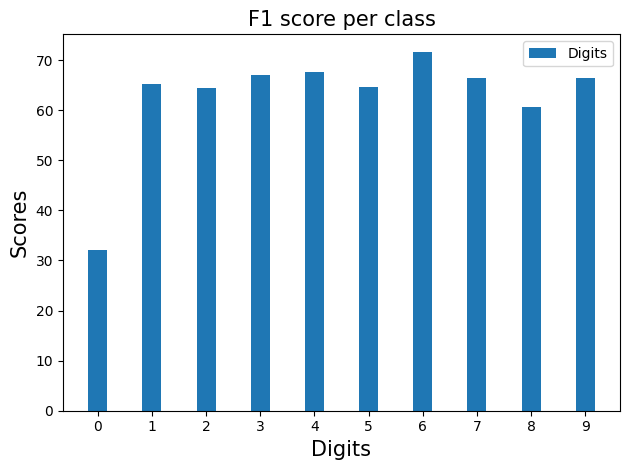

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

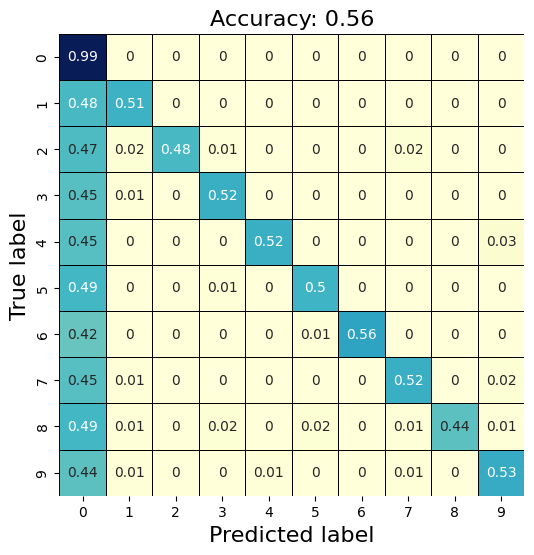

In [ ]:
plot_confusion_heatmap(y, y_pred_map)

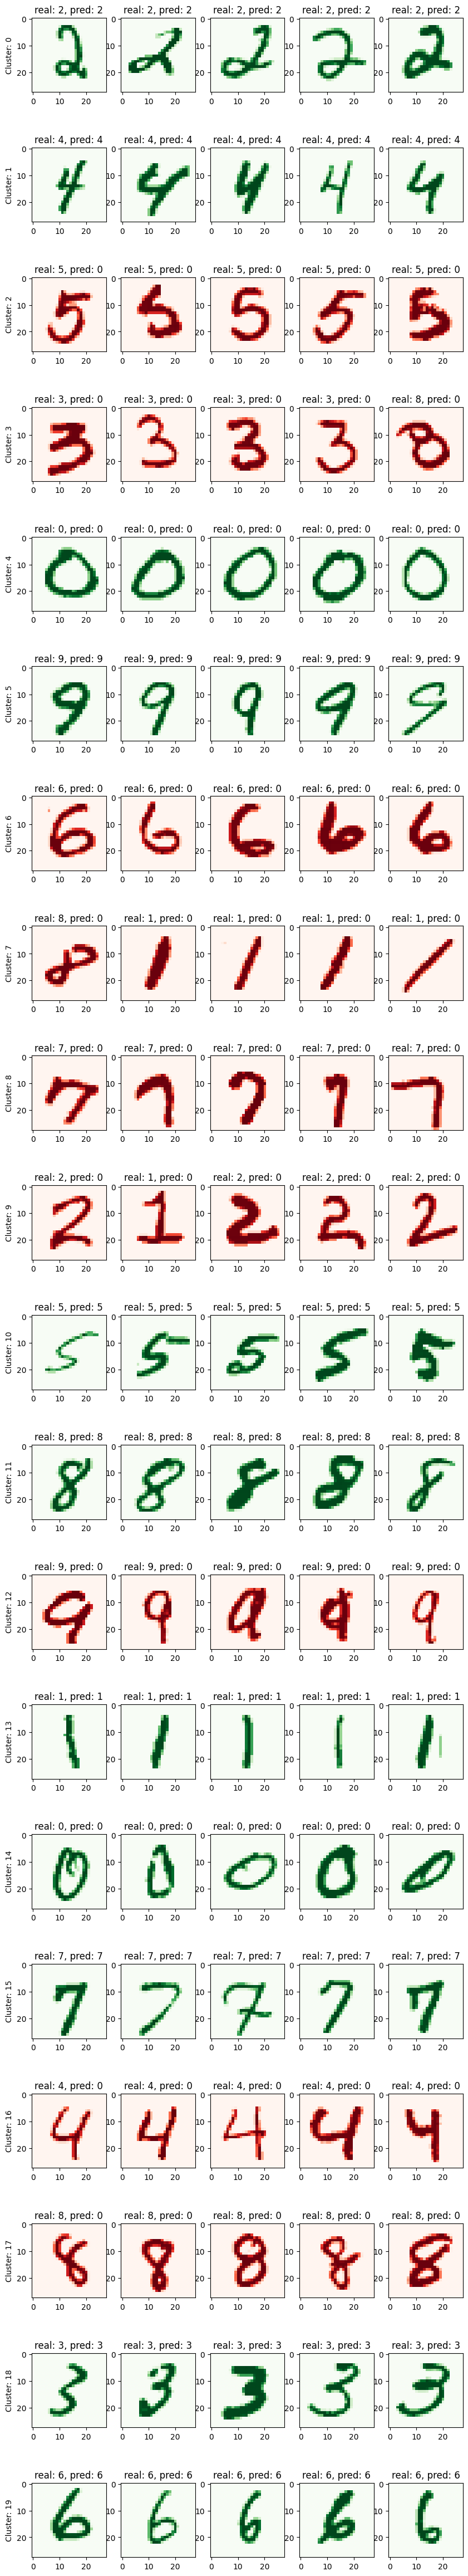

In [ ]:
plot_samples_clusters(n_clusters, 5, x, y, y_pred_map)